In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx
import networkx.algorithms.community as nx_comm

from matplotlib.lines import Line2D

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

In [2]:
billboard_hot_100.dtypes
plt.rcParams.update({'font.size': 15})

In [3]:
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
from datetime import timedelta

grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)


In [5]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

In [6]:
distributions = {}
distributions_normalized = {}

billboard_subset = billboard_hot_100_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1958, 2023):
    year_subset = billboard_subset[billboard_subset["year"] == year]["position_change"]
    count_changes = year_subset.value_counts().sort_index()
    distributions[year] = count_changes

    # save normalized distribution
    distributions_normalized[year] = count_changes / count_changes.sum()


In [7]:
def bhattacharyya_distance(distribution1, distribution2):
    return -math.log(sum(math.sqrt(x * y) for x, y in zip(distribution1, distribution2)))

In [8]:
distances_bhattacharyya = {}

for year_1 in range(1958, 2023):
    for year_2 in range(1958, 2023):
        if year_1 not in distances_bhattacharyya:
            distances_bhattacharyya[year_1] = {}
        distances_bhattacharyya[year_1][year_2] = bhattacharyya_distance(
            distributions_normalized[year_1].values, distributions_normalized[year_2].values)

In [9]:
histograms_network = nx.Graph()

for year in range(1958, 2023):
    histograms_network.add_node(year)

for year_1 in range(1958, 2023):
    for year_2 in range(1958, 2023):
        if year_1 != year_2:
            histograms_network.add_edge(year_1, year_2, weight=distances_bhattacharyya[year_1][year_2])

In [10]:
communities = nx_comm.louvain_communities(histograms_network, seed=123)

for i, community in enumerate(communities):
    print(f"Community {i}:")
    print(sorted(community))

Community 0:
[1958, 1959, 1960, 1962, 1966, 1967, 1968, 1969, 1972, 1973, 1974, 1975, 1978, 1979, 1980, 1981, 1982, 1987, 1992, 1993, 1995, 1996, 1997, 1999, 2002, 2003, 2004, 2007, 2008, 2009, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Community 1:
[1961, 1963, 1964, 1965, 1970, 1971, 1976, 1977, 1983, 1984, 1985, 1986, 1988, 1989, 1990, 1991, 1994, 1998, 2000, 2001, 2005, 2006, 2010, 2011, 2019, 2020, 2021, 2022]


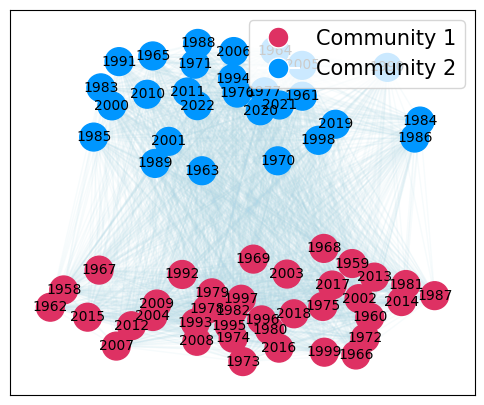

In [12]:
plt.figure(figsize=(6, 5))

color_map = ["#DE3163" if node in communities[0] else "#0096FF" for node in histograms_network]    
colormap = ["#DE3163", "#0096FF"]

node_pos = nx.spring_layout(histograms_network.to_undirected())

# shift one group down
for node in histograms_network:
    if node in communities[1]:
        node_pos[node][1] += 3

nx.draw_networkx_labels(histograms_network, node_pos, font_size=10)
nx.draw_networkx_nodes(histograms_network, node_pos, node_color=color_map, node_size=400)
nx.draw_networkx_edges(histograms_network, node_pos, alpha=0.1, edge_color="lightblue")

legend_elements = []
for i, community in enumerate(communities):
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=f"Community {i + 1}", markerfacecolor=colormap[i], markersize=15))

plt.legend(handles=legend_elements, loc='upper right', prop={'size': 15},
    fontsize=15)
plt.show()